In [174]:
import pandas as pd
import os, types
import io, requests
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Import cleaned data

## Import west data

In [175]:
west_electricity_weather_history = pd.read_csv('https://raw.githubusercontent.com/AmLunaW/datathon-code/Pouya/Cleaned%20Files_PS1/west_electricity_weather_history.csv')
west_df = west_electricity_weather_history.drop(['index'], axis=1)
n_rows, n_cols = west_df.shape
west_df

,West,tempF,windspeedMiles,precipMM,humidity,visibilityMiles,pressureInches,cloudcover,HeatIndexF,DewPointF,WindChillF,WindGustMiles,FeelsLikeF,uvIndex
0,829.419681,68.0,7.0,0.0,70.0,6.0,31.0,8.0,68.0,58.0,68.0,15.0,68.0,5.0
1,798.814534,68.0,7.0,0.0,70.0,6.0,31.0,8.0,68.0,58.0,68.0,15.0,68.0,5.0
2,774.195122,81.0,9.0,0.0,55.0,6.0,31.0,7.0,83.0,64.0,81.0,11.0,83.0,7.0
3,763.004208,81.0,9.0,0.0,55.0,6.0,31.0,7.0,83.0,64.0,81.0,11.0,83.0,7.0
4,780.990754,81.0,9.0,0.0,55.0,6.0,31.0,7.0,83.0,64.0,81.0,11.0,83.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113213,1393.890000,65.0,8.0,3.7,94.0,4.0,30.0,71.0,65.0,64.0,65.0,15.0,65.0,1.0
113214,1397.910000,65.0,8.0,3.7,94.0,4.0,30.0,71.0,65.0,64.0,65.0,15.0,65.0,1.0
113215,1374.300000,64.0,7.0,2.8,97.0,5.0,30.0,83.0,64.0,63.0,64.0,12.0,64.0,1.0
113216,1269.350000,64.0,7.0,2.8,97.0,5.0,30.0,83.0,64.0,63.0,64.0,12.0,64.0,1.0


# Split to training and test sets

In [176]:
train_data= west_df.iloc[:n_rows-300]
test_data = west_df.iloc[-300:]

print(len(train_data), len(test_data))

112918 300


# Feature scaling

In [177]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0,1))

## Scale west data

In [178]:
train_data_scaled = min_max_scaler.fit_transform(train_data)
train_data_scaled = pd.DataFrame(train_data_scaled)
train_data_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.148929,0.62963,0.194444,0.0,0.696970,1.0,1.0,0.08,0.618182,0.868613,0.687500,0.283019,0.676923,0.444444
1,0.128705,0.62963,0.194444,0.0,0.696970,1.0,1.0,0.08,0.618182,0.868613,0.687500,0.283019,0.676923,0.444444
2,0.112437,0.75000,0.250000,0.0,0.545455,1.0,1.0,0.07,0.754545,0.912409,0.789062,0.207547,0.792308,0.666667
3,0.105043,0.75000,0.250000,0.0,0.545455,1.0,1.0,0.07,0.754545,0.912409,0.789062,0.207547,0.792308,0.666667
4,0.116928,0.75000,0.250000,0.0,0.545455,1.0,1.0,0.07,0.754545,0.912409,0.789062,0.207547,0.792308,0.666667


In [179]:
test_data_scaled = min_max_scaler.fit_transform(test_data)
test_data_scaled = pd.DataFrame(test_data_scaled)
test_data_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.308293,0.50000,0.6875,0.019934,0.452830,1.0,0.0,0.715789,0.483871,0.333333,0.50000,0.541667,0.555556,0.0
1,0.368338,0.50000,0.6875,0.019934,0.452830,1.0,0.0,0.715789,0.483871,0.333333,0.50000,0.541667,0.555556,0.0
2,0.480956,0.50000,0.6875,0.019934,0.452830,1.0,0.0,0.715789,0.483871,0.333333,0.50000,0.541667,0.555556,0.0
3,0.774271,0.34375,0.4375,0.013289,0.792453,1.0,0.0,0.652632,0.225806,0.444444,0.34375,0.458333,0.305556,0.0
4,0.840192,0.34375,0.4375,0.013289,0.792453,1.0,0.0,0.652632,0.225806,0.444444,0.34375,0.458333,0.305556,0.0


### 3. Separate data into dependent and independent variables

#### 3.1 Pairwise plot

In [180]:
#import seaborn as sns

#sns.pairplot(train_data_scaled)

In [181]:
X_train = pd.DataFrame(train_data_scaled[[1,2,3,4,5,7,8,9,10,11,12,13]])
y_train = pd.DataFrame(train_data_scaled[0])

X_test = pd.DataFrame(test_data_scaled[[1,2,3,4,5,7,8,9,10,11,12,13]])
y_test = pd.DataFrame(test_data_scaled[0])

In [182]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape )

(112918, 12) (112918, 1) (300, 12) (300, 1)


In [183]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
        if(i%10000==0):
            print('i = ',i)
            print('i + time_steps = ',i+time_steps)
        
    return np.array(Xs), np.array(ys)

In [184]:
time_steps = 24

X_train_steps, y_train_steps = create_dataset(X_train, y_train, time_steps)
print(X_train_steps.shape, y_train_steps.shape)

i =  0
i + time_steps =  24
i =  10000
i + time_steps =  10024
i =  20000
i + time_steps =  20024
i =  30000
i + time_steps =  30024
i =  40000
i + time_steps =  40024
i =  50000
i + time_steps =  50024
i =  60000
i + time_steps =  60024
i =  70000
i + time_steps =  70024
i =  80000
i + time_steps =  80024
i =  90000
i + time_steps =  90024
i =  100000
i + time_steps =  100024
i =  110000
i + time_steps =  110024
(112894, 24, 12) (112894, 1)


In [185]:
X_test_steps, y_test_steps = create_dataset(X_test, y_test, time_steps)
print(X_test.shape, y_test.shape)

i =  0
i + time_steps =  24
(300, 12) (300, 1)


In [186]:
print(X_test_steps.shape, y_test_steps.shape)

(276, 24, 12) (276, 1)


In [187]:
#print(X_test_steps.shape[2])

## 4. Use Tensorflow and Keras

In [188]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [189]:
model = Sequential()

model.add(LSTM(units=100,input_shape=(X_train_steps.shape[1], X_train_steps.shape[2])))

model.add(tf.keras.layers.Dense(units=1))
#model.add(Dropout(0.5))

model.compile(loss = root_mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(0.001))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               45200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 45,301
Trainable params: 45,301
Non-trainable params: 0
_________________________________________________________________


In [190]:
tf.random.set_seed(1234)
history = model.fit(
    X_train_steps[len(X_train_steps)-500:len(X_train_steps),:], y_train_steps[len(y_train_steps)-500:len(y_train_steps)],
    epochs=15,
    batch_size=100,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/15
5/5 [==============================] - 2s 146ms/step - loss: 0.2759 - val_loss: 0.2822
Epoch 2/15
5/5 [==============================] - 0s 43ms/step - loss: 0.1937 - val_loss: 0.1126
Epoch 3/15
5/5 [==============================] - 0s 46ms/step - loss: 0.1342 - val_loss: 0.1259
Epoch 4/15
5/5 [==============================] - 0s 46ms/step - loss: 0.1316 - val_loss: 0.0902
Epoch 5/15
5/5 [==============================] - 0s 43ms/step - loss: 0.1289 - val_loss: 0.0693
Epoch 6/15
5/5 [==============================] - 0s 46ms/step - loss: 0.1069 - val_loss: 0.1092
Epoch 7/15
5/5 [==============================] - 0s 43ms/step - loss: 0.1084 - val_loss: 0.0706
Epoch 8/15
5/5 [==============================] - 0s 42ms/step - loss: 0.1082 - val_loss: 0.0715
Epoch 9/15
5/5 [==============================] - 0s 44ms/step - loss: 0.0928 - val_loss: 0.0911
Epoch 10/15
5/5 [==============================] - 0s 46ms/step - loss: 0.0970 - val_loss: 0.0740
Epoch 11/15
5/5 [===========

## Plot the training and validation accuracy and loss (root_mean_squared_error) at each epoch

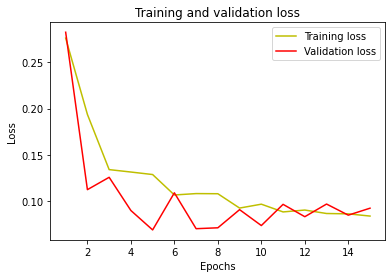

In [191]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [192]:
predicted_electricity_load = model.predict(X_test_steps)

In [193]:
#print(predicted_electricity_load)

In [194]:
print(X_test_steps.shape)

(276, 24, 12)


In [195]:
lenth = len(predicted_electricity_load)
print(lenth)

276


In [196]:
predicted_np = np.column_stack( (predicted_electricity_load , np.ones((lenth,13)) ))

In [197]:
print(predicted_np.shape)

(276, 14)


In [198]:
predicted_electricity_load_inverse = min_max_scaler.inverse_transform(predicted_np)

In [199]:
#predicted_electricity_load_inverse

In [200]:
actual_np = np.column_stack( (y_test_steps , np.ones((lenth,13)) ) )

In [201]:
actual_electricity_load_inverse = min_max_scaler.inverse_transform(actual_np)

In [202]:
#actual_electricity_load_inverse

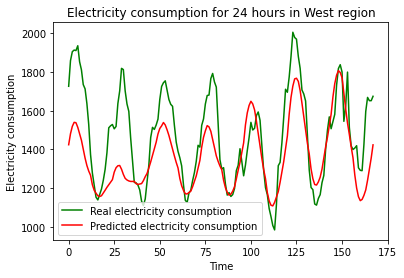

In [203]:
plt.plot(actual_electricity_load_inverse[0:168,0], color='green', label = 'Real electricity consumption')
plt.plot(predicted_electricity_load_inverse[0:168,0], color='red', label = 'Predicted electricity consumption')
plt.title('Electricity consumption for 24 hours in West region')
plt.xlabel('Time')
plt.ylabel('Electricity consumption')
plt.legend()
plt.show()

# Predict for June 13-19

In [228]:
df = pd.read_csv('https://raw.githubusercontent.com/WiDSTexas2021/datathon-code/main/data/ercot_hourly_load.csv')
recent_load = df[-192:]

In [229]:
west_new = pd.read_csv('https://raw.githubusercontent.com/AmLunaW/cleaned-data/main/weather_forecasting_Abilene.csv')
west_new['West'] = recent_load['West'].values
test_data_new = west_new.drop(['date_time'], axis=1)
# test_data_new['Coast'] = recent_load['Coast']
test_data_new.head()

,West,tempF,windspeedMiles,precipMM,humidity,visibilityMiles,pressureInches,cloudcover,HeatIndexF,DewPointF,WindChillF,WindGustMiles,FeelsLikeF,uvIndex
0,1099.03,85,18,0.0,44,6,30,7,88,59,85,32,88,1
1,1039.49,85,18,0.0,44,6,30,7,88,59,85,32,88,1
2,1038.03,85,18,0.0,44,6,30,7,88,59,85,32,88,1
3,1019.19,77,12,0.0,57,6,30,4,80,61,77,23,80,1
4,1030.11,77,12,0.0,57,6,30,4,80,61,77,23,80,1


In [230]:
test_data_new_scaled = min_max_scaler.fit_transform(test_data_new)
test_data_new_scaled = pd.DataFrame(test_data_new_scaled)
test_data_new_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.084074,0.444444,0.882353,0.0,0.363636,1.0,0.0,0.079545,0.423077,0.307692,0.444444,1.000000,0.423077,0.0
1,0.033592,0.444444,0.882353,0.0,0.363636,1.0,0.0,0.079545,0.423077,0.307692,0.444444,1.000000,0.423077,0.0
2,0.032354,0.444444,0.882353,0.0,0.363636,1.0,0.0,0.079545,0.423077,0.307692,0.444444,1.000000,0.423077,0.0
3,0.016381,0.148148,0.529412,0.0,0.600000,1.0,0.0,0.045455,0.115385,0.461538,0.148148,0.666667,0.115385,0.0
4,0.025639,0.148148,0.529412,0.0,0.600000,1.0,0.0,0.045455,0.115385,0.461538,0.148148,0.666667,0.115385,0.0


In [231]:
X_new = pd.DataFrame(test_data_new_scaled[[1,2,3,4,5,7,8,9,10,11,12,13]])
y_new = pd.DataFrame(test_data_new_scaled[0])

In [232]:
X_new_steps, y_new_steps = create_dataset(X_new, y_new, time_steps)
print(X_new_steps.shape)

i =  0
i + time_steps =  24
(168, 24, 12)


In [233]:
predicted_new = model.predict(X_new_steps)

In [234]:
lenth = len(predicted_new) 
print(lenth)

168


In [235]:
predicted_new_np = np.column_stack( (predicted_new , np.ones((lenth,13)) ))

In [236]:
predicted_new_load_inverse = min_max_scaler.inverse_transform(predicted_new_np)

In [237]:
west_load_pre = predicted_new_load_inverse[:,0]
west_load_pre

array([1958.98202779, 1964.52631565, 1903.4970394 , 1815.49270002,
       1673.27081279, 1571.60885075, 1499.13932251, 1430.54529831,
       1411.87752796, 1419.35067488, 1442.84008319, 1481.90996256,
       1528.08911551, 1590.3469212 , 1643.94758565, 1691.11635314,
       1755.20009854, 1804.4063739 , 1828.44851676, 1782.02022024,
       1698.74904614, 1600.91611977, 1539.34767689, 1461.03508535,
       1384.4688538 , 1313.23875152, 1250.25302342, 1198.50274554,
       1152.16793058, 1140.91910577, 1148.21662546, 1174.88475834,
       1228.96711909, 1292.07165436, 1325.85210131, 1371.27429791,
       1416.27845496, 1471.96362289, 1514.11802469, 1546.20949411,
       1639.3078492 , 1698.18102132, 1731.34853925, 1733.22442718,
       1693.26556787, 1635.91713467, 1553.14136539, 1459.19350387,
       1370.36229469, 1283.88775583, 1209.40866402, 1149.47251921,
       1076.2998142 , 1048.93792476, 1047.23920627, 1083.2950083 ,
       1146.01827096, 1218.23898956, 1314.58837288, 1412.97976

Text(0.5, 1.0, 'Hourly_load for West June 13-19')

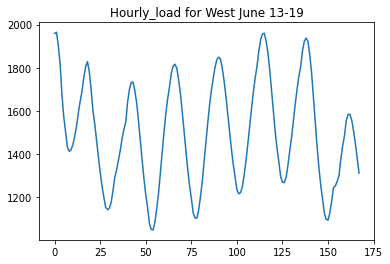

In [240]:
plt.plot(west_load_pre)
plt.title('Hourly_load for West June 13-19')
